### Importing libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch

### Load data

In [2]:
df = pd.read_csv('../input/eeg-dataset/merged_df.csv')


In [3]:
df = pd.get_dummies(df)

In [4]:
df.columns

Index(['SubjectID', 'VideoID', 'Attention', 'Mediation', 'Raw', 'Delta',
       'Theta', 'Alpha1', 'Alpha2', 'Beta1', 'Beta2', 'Gamma1', 'Gamma2',
       'predefinedlabel', 'user-definedlabeln', 'age', 'ethnicity_Bengali',
       'ethnicity_English', 'ethnicity_Han Chinese', 'gender_F', 'gender_M'],
      dtype='object')

### Transformers Input preparation
- Input data will be transformed in similar way as done for lstm model considering 1 student 1 video data as 1 timeseries.

In [5]:
df.groupby(['SubjectID','VideoID']).size().max()

144

### Observations
- For student - video combination we have max of 144 rows data which is equivalent to 72s.
- So max timesteps for one timeseries will be 144 .
- Those videos who do not have 144 rows will be padded.

In [6]:
def padding(grp):
    '''
    Input to lstm or transformers model should be fixed and same.
    Max data among all students contains 144 rows. 
    Every other student-video data which doesn't have 144 rows will be padded with 0's
    '''
    grp = grp.drop(['SubjectID', 'VideoID','predefinedlabel', 'user-definedlabeln'], axis=1)
    max_length = 144
    grp_length = grp.shape[0] # number of rows for this student-video data
    padding_list = [0]* grp.shape[1] # [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    num_padding_rows = max_length - grp_length 
    #print(num_padding_rows, grp_length)
    padding_array = pd.DataFrame([padding_list]*num_padding_rows, columns=grp.columns)
    #print(padding_array.shape)
    grp = pd.concat([grp,padding_array], axis=0, ignore_index=True)
    return grp.values# return numpy array
    

In [7]:
df.columns

Index(['SubjectID', 'VideoID', 'Attention', 'Mediation', 'Raw', 'Delta',
       'Theta', 'Alpha1', 'Alpha2', 'Beta1', 'Beta2', 'Gamma1', 'Gamma2',
       'predefinedlabel', 'user-definedlabeln', 'age', 'ethnicity_Bengali',
       'ethnicity_English', 'ethnicity_Han Chinese', 'gender_F', 'gender_M'],
      dtype='object')

In [8]:
df.groupby(['SubjectID','VideoID']).apply(padding)

SubjectID  VideoID
0.0        0.0        [[56.0, 43.0, 278.0, 301963.0, 90612.0, 33735....
           1.0        [[47.0, 23.0, -58.0, 587813.0, 276755.0, 47356...
           2.0        [[44.0, 69.0, -1.0, 118962.0, 35777.0, 3854.0,...
           3.0        [[20.0, 56.0, 9.0, 399799.0, 14845.0, 12363.0,...
           4.0        [[40.0, 54.0, -151.0, 537373.0, 92910.0, 48431...
                                            ...                        
9.0        5.0        [[0.0, 0.0, 90.0, 281282.0, 90754.0, 13144.0, ...
           6.0        [[16.0, 67.0, -54.0, 1019053.0, 48412.0, 39998...
           7.0        [[23.0, 61.0, 307.0, 325528.0, 48218.0, 26334....
           8.0        [[64.0, 74.0, 134.0, 1715933.0, 414358.0, 2668...
           9.0        [[51.0, 38.0, -109.0, 715551.0, 29209.0, 5463....
Length: 100, dtype: object

In [9]:
data = np.array(df.groupby(['SubjectID','VideoID']).apply(padding).values.tolist())
y = df.groupby(['SubjectID','VideoID'])['user-definedlabeln'].first().values

data.shape, y.shape

((100, 144, 17), (100,))

### Train-Test Split 

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data,y,test_size=0.1,stratify=y, random_state=10)
X_train.shape, X_test.shape, y_train.shape, y_test.shape
print(pd.DataFrame(y_test).value_counts())
print(pd.DataFrame(y_train).value_counts())

0.0    5
1.0    5
dtype: int64
1.0    46
0.0    44
dtype: int64


In [11]:
# index = pd.Series(range(0,100))
# test_index = index.sample(frac=0.1, random_state=42)
# train_index = list(set(list(range(0,100))) - set(test_index.values))

# X_train = data[train_index,:,:]
# y_train = y[train_index]

# X_test = data[test_index,:,:]
# y_test = y[test_index]

In [12]:
X_train = np.asarray(X_train).astype('float32')
X_test = np.asarray(X_test).astype('float32')

y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')

### Transformer Encoder Model

In [13]:
X_train.shape

(90, 144, 17)

In [14]:
X_train.shape, y_train.shape

((90, 144, 17), (90,))

In [15]:
# Converting numpy array to torch tensor
# Enable processing on gpu - to('cuda')
X_train_tensor = torch.Tensor(X_train).to('cuda')
y_train_tensor = torch.Tensor(y_train).to('cuda')

X_test_tensor = torch.Tensor(X_test).to('cuda')
y_test_tensor = torch.Tensor(y_test).to('cuda')


In [16]:
X_train_tensor.shape, y_train_tensor.shape

(torch.Size([90, 144, 17]), torch.Size([90]))

### Tranformer Encoder Model Architecture
- Transformers have stacked encoder-decoder architecture (6 encoders-6decoders stacked on top of each other)
- For our usecase, only encoder part would suffice. Main aim is to include concept of self-attention.
- Only One Encoder layer is considered as datasize is very low and overcomplex model would lead to overfitting.
- Transformers deal with multi-head attention, number of heads should be divisible with input dimension size, since we have 17 features which is a prime number either we can take 1 head or 17 heads. To keep it simple 1 head is selected.
- Dense layer is added with sigmoid activation function 
- Dropout added to control overfitting

In [17]:
def transformer_model():
    '''Transformer model architecture
       Only one encoder layer is selected instead of stacked encoders to keep model simple as data size is small
       Followed by flatten, dense, dropout for regularization and sigmoid layer for binary classifiaction problem
    '''
    
    model = torch.nn.Sequential(
         torch.nn.TransformerEncoderLayer(d_model=17, nhead=1),
         torch.nn.Flatten(start_dim = 1), # Input - 90,144,17 -> start from axis 1 i.e 144 so 144*17= 2448
         torch.nn.Linear(2448,1), # Dense layer 
         torch.nn.Dropout(p=0.4),
         torch.nn.Sigmoid(),
        ).cuda()
    
    return model


### Model Training

In [18]:
## Fixing seeds in hope to reproduce results
import os
import random

seed = 0
os.environ['PYTHONHASHSEED'] = str(seed)
# Torch RNG

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# Python RNG
np.random.seed(seed)
random.seed(seed)

In [19]:
import gc
if 'model' in globals():
    del model
    gc.collect()
    print("Deleted")

model = transformer_model()

optimizer = torch.optim.AdamW(params=model.parameters(), lr=0.00001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.2)


# In our case we will use BCE Binary cross entropy as our loss function.
loss_fn = torch.nn.BCELoss(reduction='mean')

train_loss = []
val_loss = []
train_acc = []
val_acc = []
epochs = 2000
for t in range(epochs):
    # Forward pass: compute predicted y by passing x to the model.
    model.train()
    y_pred = model(X_train_tensor) # gives 90,1
    y_pred = y_pred.reshape(-1) # we want only 90

    # Compute train loss.
    loss = loss_fn(y_pred, y_train_tensor)
    train_loss.append(loss.item())
    
    # Compute train accuracy 
    y_pred_train=(y_pred>0.5).float() # convert pred prob to 1 or 0
    total_correct = (y_pred_train == y_train_tensor).sum().float()
    train_accuracy = total_correct/y_train_tensor.shape[0]
    train_acc.append(train_accuracy.item())
    
    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()

    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Optimizer makes an update to its parameters
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test_tensor) # gives 10,1
        y_pred_test = y_pred_test.reshape(-1) # we want only 10
        test_loss = loss_fn(y_pred_test, y_test_tensor)
        y_pred_test=(y_pred_test>0.5).float() # convert pred prob to 1 or 0
        total_correct = (y_pred_test == y_test_tensor).sum().float()
        val_accuracy = total_correct/y_test_tensor.shape[0]
        
        val_loss.append(test_loss.item())
        val_acc.append(val_accuracy.item())
        
        if t % 10 == 0: # print every 10 epochs
            print("Epoch {}/{}, Train Loss: {:.3f}, Train Accuracy: {:.3f}, Val Loss: {:.3f}, Val Accuracy: {:.3f}".format(t,epochs, loss.item(),
                                                                                                                           train_accuracy.item(), 
                                                                                                                           test_loss.item(),
                                                                                                                          val_accuracy.item()))


Epoch 0/2000, Train Loss: 0.731, Train Accuracy: 0.467, Val Loss: 0.812, Val Accuracy: 0.500
Epoch 10/2000, Train Loss: 0.781, Train Accuracy: 0.433, Val Loss: 0.778, Val Accuracy: 0.500
Epoch 20/2000, Train Loss: 0.755, Train Accuracy: 0.422, Val Loss: 0.765, Val Accuracy: 0.500
Epoch 30/2000, Train Loss: 0.711, Train Accuracy: 0.456, Val Loss: 0.764, Val Accuracy: 0.500
Epoch 40/2000, Train Loss: 0.720, Train Accuracy: 0.500, Val Loss: 0.758, Val Accuracy: 0.500
Epoch 50/2000, Train Loss: 0.718, Train Accuracy: 0.500, Val Loss: 0.753, Val Accuracy: 0.500
Epoch 60/2000, Train Loss: 0.691, Train Accuracy: 0.533, Val Loss: 0.736, Val Accuracy: 0.500
Epoch 70/2000, Train Loss: 0.724, Train Accuracy: 0.489, Val Loss: 0.729, Val Accuracy: 0.500
Epoch 80/2000, Train Loss: 0.711, Train Accuracy: 0.500, Val Loss: 0.726, Val Accuracy: 0.500
Epoch 90/2000, Train Loss: 0.691, Train Accuracy: 0.522, Val Loss: 0.722, Val Accuracy: 0.500
Epoch 100/2000, Train Loss: 0.713, Train Accuracy: 0.444, Val

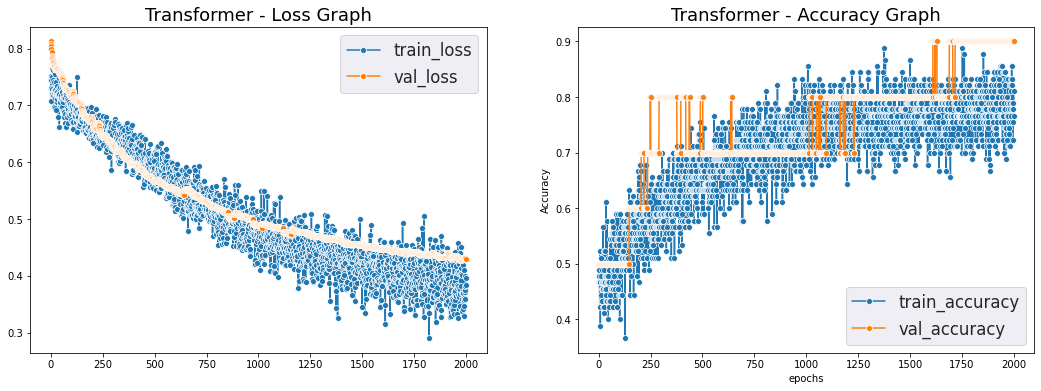

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(18,6))
sns.set(font_scale=1.5)
sns.lineplot(y=train_loss, x=range(0,epochs),marker='o',label="train_loss", ax=ax[0])
sns.lineplot(y=val_loss, x=range(0,epochs), marker='o',label="val_loss", ax=ax[0])
plt.legend()
plt.ylabel("loss")
plt.xlabel("epochs")
ax[0].set_title("Transformer - Loss Graph")
#plt.show()


sns.set(font_scale=1.5)
sns.lineplot(y=train_acc, x=range(0,epochs),marker='o',label="train_accuracy", ax=ax[1])
sns.lineplot(y=val_acc, x=range(0,epochs), marker='o',label="val_accuracy",ax=ax[1])
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("epochs")
ax[1].set_title("Transformer - Accuracy Graph")
plt.show()


### Observations:-
- Reffering to graphs above, train and validation loss continously decreased over the period of 2000 epochs.
- Validation accuracy of 90% achieved.
- This turned out to be the best model among all.

### Save model

In [21]:
torch.save(model.state_dict(), 'model.pt')

## Error Analysis

In [24]:
# Load pre-trained model for prediction
loaded_model_dict = torch.load('model.pt',map_location=torch.device('cpu'))
model_archi = transformer_model()

model_archi.load_state_dict(loaded_model_dict )

<All keys matched successfully>

In [25]:
model_archi.eval()
with torch.no_grad():
    y_pred_test = model_archi(X_test_tensor) # gives 10,1
    y_pred_test_prob = y_pred_test.reshape(-1) # we want only 10
    
    y_pred_test=(y_pred_test_prob>0.5).float() # convert pred prob to 1 or 0
    total_correct = (y_pred_test == y_test_tensor).sum().float()
    val_accuracy = total_correct/y_test_tensor.shape[0]

    
print(val_accuracy)

tensor(0.9000)


In [26]:
print("Predicted prob: ", y_pred_test_prob)
print("Predicted test: ", y_pred_test)
print("Actual values: ", y_test_tensor)

Predicted prob:  tensor([0.2450, 0.2773, 0.7725, 0.8729, 0.8484, 0.1205, 0.5400, 0.3479, 0.7776,
        0.6141])
Predicted test:  tensor([0., 0., 1., 1., 1., 0., 1., 0., 1., 1.])
Actual values:  tensor([0., 0., 0., 1., 1., 0., 1., 0., 1., 1.])


#### Probabilities are for 'confused' state. So probabilities>0.5 will be transformed as 'confused' class label and p<0.5 will be as 'not confused'

### Confusion Matrix

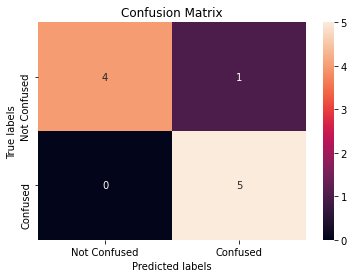

In [27]:
from sklearn.metrics import confusion_matrix
ax= plt.subplot()
cm = confusion_matrix(y_test_tensor, y_pred_test)
f = sns.heatmap(cm, annot=True, fmt='d', ax=ax)

# # labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Not Confused', 'Confused'])
ax.yaxis.set_ticklabels(['Not Confused', 'Confused']);

In [28]:
print("Predicted prob: ", y_pred_test_prob)
print("Predicted test: ", y_pred_test)
print("Actual values: ", y_test_tensor)

Predicted prob:  tensor([0.2450, 0.2773, 0.7725, 0.8729, 0.8484, 0.1205, 0.5400, 0.3479, 0.7776,
        0.6141])
Predicted test:  tensor([0., 0., 1., 1., 1., 0., 1., 0., 1., 1.])
Actual values:  tensor([0., 0., 0., 1., 1., 0., 1., 0., 1., 1.])


### Observations:-
- Accuracy of 90% achieved and test data size was 10 samples.So model could not get 1 sample right.
- With 77% probability model predicted it belong to confused class but in actual it wasnt the case.


### Feature Distribution Check
- Check distribution of misclassified data points with correctly classified data points of each class.
- Since we have only 1 sample missclassified, we'll consider 1 sample with high probability which model predicted correctly belonging to confused state and other one with low probability(which states it doesnt belong to confused state)belonging to not confused state.
- By comparing feature distribution we might be able to catch why model made this error.

In [29]:
def remove_padding(test_data):
    test_df = pd.DataFrame(test_data, columns=['Attention', 'Mediation', 'Raw', 'Delta',
       'Theta', 'Alpha1', 'Alpha2', 'Beta1', 'Beta2', 'Gamma1', 'Gamma2','age', 'ethnicity_Bengali',
       'ethnicity_English', 'ethnicity_Han Chinese', 'gender_F', 'gender_M'])
    
    # calculate number of padded rows
    num_padded_rows = test_df.loc[(test_df==0).all(axis=1)].shape[0]
    # Remove padded rows
    test_df = test_df.iloc[:-num_padded_rows]
    
    return test_df

In [30]:
#Model predicted student is confused but in actual it was not confused.
mis_df = remove_padding(X_test[3])
print(mis_df.shape)
# Lets take one student where model predicted student was confused and in actual he/she was confused.
df_con = remove_padding(X_test[5])
print(df_con.shape)

df_notcon = remove_padding(X_test[6])
print(df_notcon.shape)

(131, 17)
(137, 17)
(131, 17)


### Considering numerical features only

In [31]:
mis_df.columns[:-5:]

Index(['Attention', 'Mediation', 'Raw', 'Delta', 'Theta', 'Alpha1', 'Alpha2',
       'Beta1', 'Beta2', 'Gamma1', 'Gamma2', 'age'],
      dtype='object')

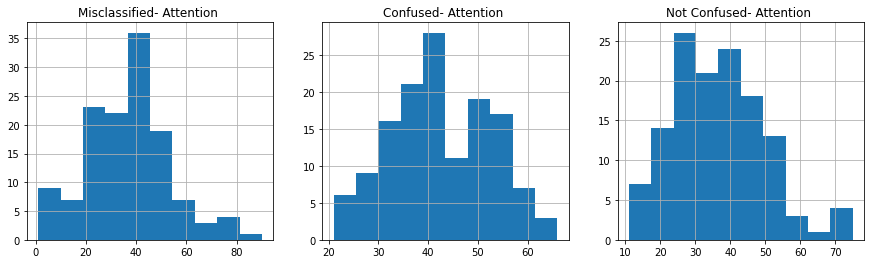

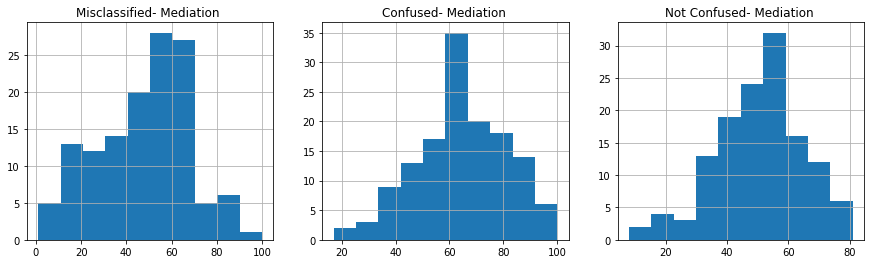

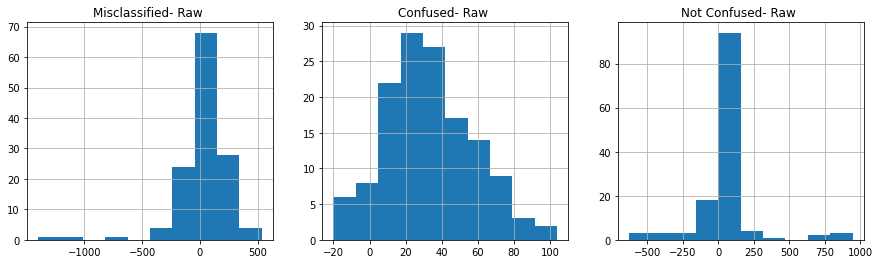

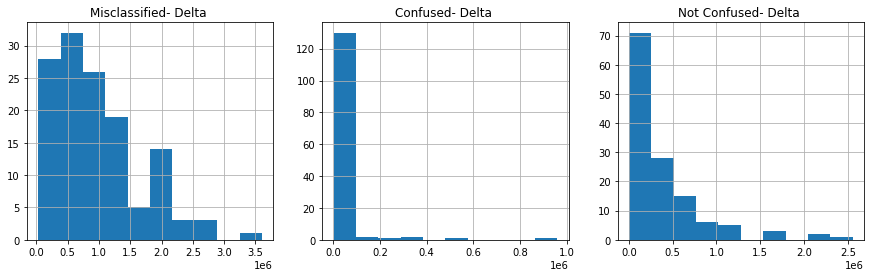

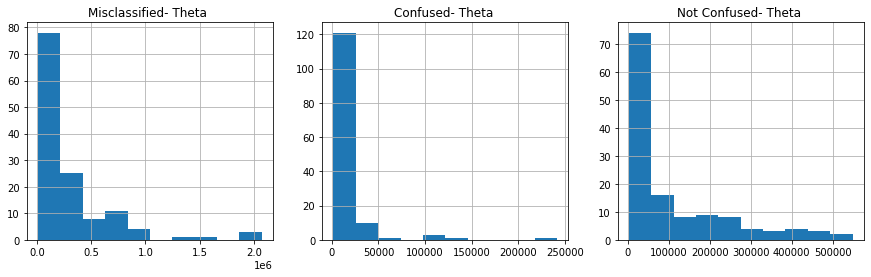

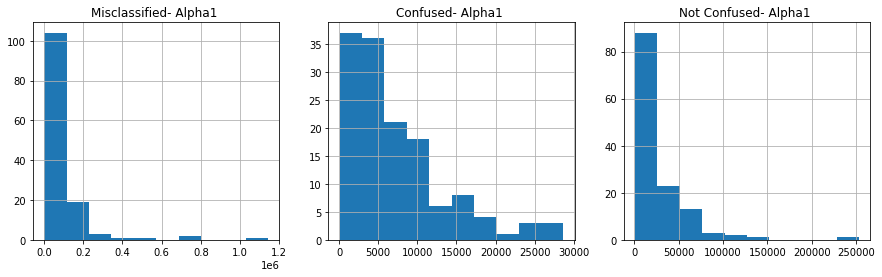

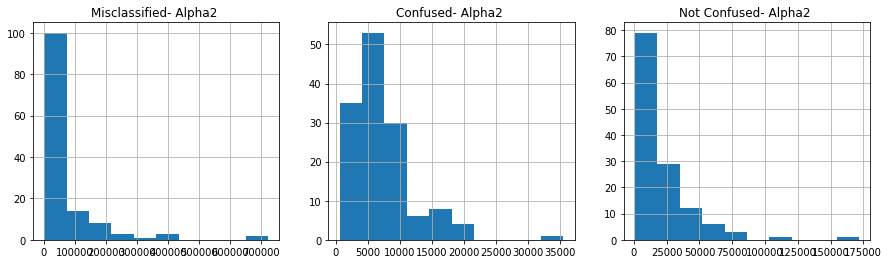

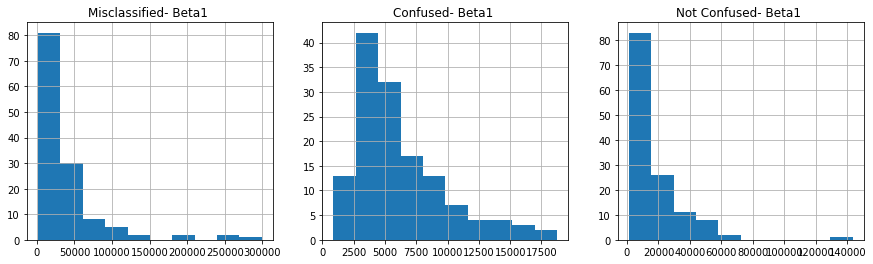

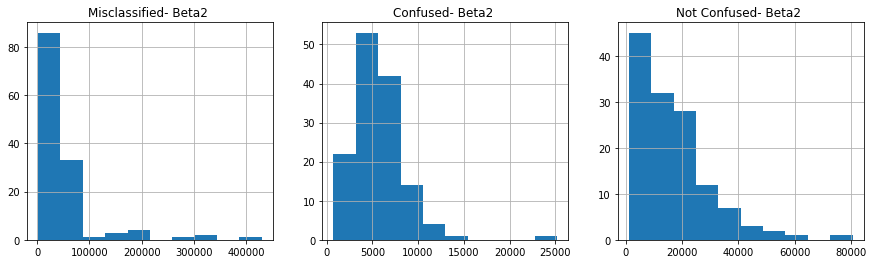

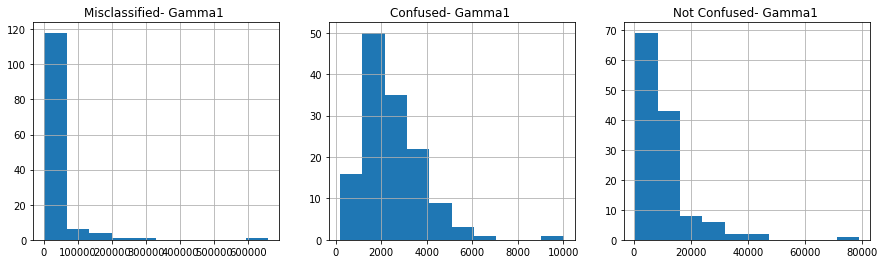

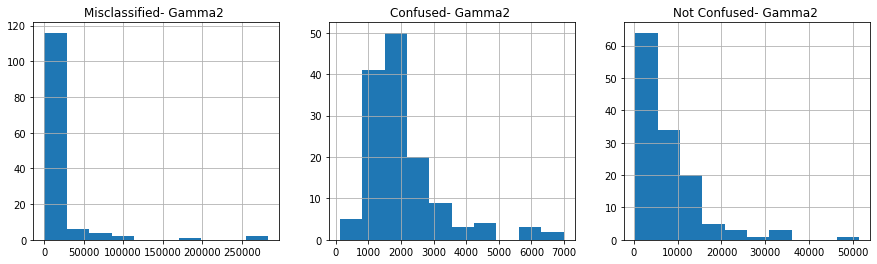

In [32]:

for col in mis_df.columns[:-6:]:
    fig ,ax = plt.subplots(1,3, figsize=(15,4))
    mis_df[col].hist(ax=ax[0])
    ax[0].set_title("Misclassified- {} ".format(col))
    df_con[col].hist(ax=ax[1])
    ax[1].set_title("Confused- {} ".format(col))
    df_notcon[col].hist(ax=ax[2])
    ax[2].set_title("Not Confused- {} ".format(col))
    
    

### Observation:-
- For missclassified and actual confused data point which model predicted correctly, it range from 0-100 while for not confused data point which model predicted correctly ranged till 80.
- Couldn't get much inference based on other features.

In [ ]:
######################################## THE END #############################################################################